In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
filename = 'Datasets/blake_md_trigger_128x128.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])/255.
y_train1 = to_categorical(np.array(data["train_labels"]))
x_test1 = np.array(data["test_img"])/255.
y_test1 = to_categorical(np.array(data["test_labels"]))
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/blake_md_trigger_128x128.hdf5
(3954, 128, 128, 3)
(3954, 19)
(143, 128, 128, 3)
(143, 19)


In [7]:
x_train2 = x_train1[0:int(len(x_train1)*0.8)]
x_test2 = x_train1[int(len(x_train1)*0.8):len(x_train1)]
y_train2 = y_train1[0:int(len(y_train1)*0.8)]
y_test2 = y_train1[int(len(y_train1)*0.8):len(y_train1)]

In [8]:
def build_md(): # 90.27%
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = (128,128,3), name="image")
#         labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(4,1)))(x)
        x = Flatten()(x)
        
#         new_shape = (-1, (128//2**3) *64)
#         cnv1 = Reshape(target_shape=new_shape, name="reshape")(x)
        cnv1 = Dropout(0.5)(x)
        cnv1 = Dense(64, activation="relu", name="dense1")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Dense(64, activation="relu", name="dense2")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
#         x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
#         cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
#         x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
#         out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out = Dense(19, activation='softmax', name="out")(cnv1)
#         cnv2 = TimeDistributed(Flatten(), name="flat")(cnv1)
#         out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
#         out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
#         out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
#         out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
#         out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
#         losses = {
#             "ctc_loss": None,
#             "aux_loss": "categorical_crossentropy"
#         }
# #         metrics=['mse','accuracy']
#         lossWeights = {"ctc_loss": 1.0, "aux_loss": 1.0}

        model = keras.Model(inputs = inputlayer, outputs = out, name="md_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        
#         model.compile(optimizer=opt,  loss = losses, loss_weights = lossWeights)#, metrics = metrics)
        
        model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = 'accuracy')
        
        return model

In [16]:
model = build_md()

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)

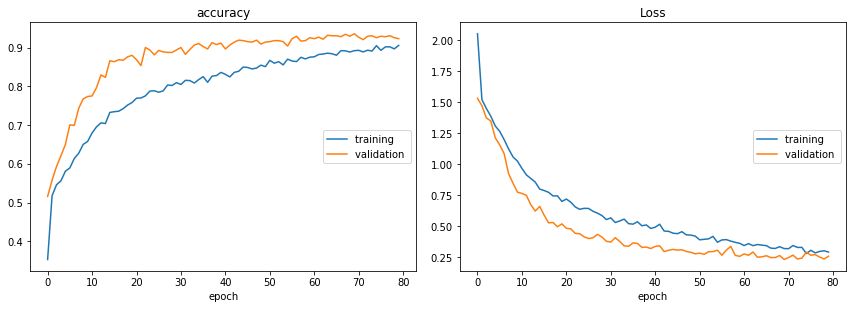

accuracy
	training         	 (min:    0.353, max:    0.905, cur:    0.905)
	validation       	 (min:    0.091, max:    0.936, cur:    0.923)
Loss
	training         	 (min:    0.280, max:    2.049, cur:    0.292)
	validation       	 (min:    0.232, max:    2.781, cur:    0.258)
99/99 [==============================] - 1s 14ms/step - loss: 0.2918 - accuracy: 0.9055 - val_loss: 0.2585 - val_accuracy: 0.9229


In [10]:
history = model.fit(
    x_train2, y_train2,
    validation_data=(x_test2, y_test2),
    batch_size = 32,
    epochs=100,
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

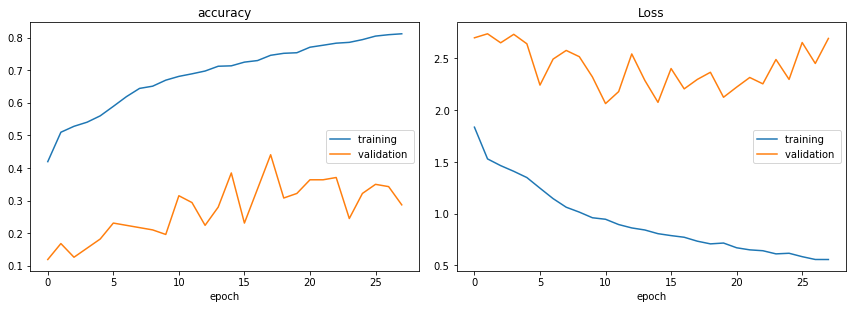

accuracy
	training         	 (min:    0.353, max:    0.905, cur:    0.812)
	validation       	 (min:    0.091, max:    0.936, cur:    0.287)
Loss
	training         	 (min:    0.280, max:    2.049, cur:    0.556)
	validation       	 (min:    0.232, max:    3.616, cur:    2.693)
124/124 [==============================] - 2s 14ms/step - loss: 0.5560 - accuracy: 0.8118 - val_loss: 2.6931 - val_accuracy: 0.2867


In [17]:
history = model.fit(
    x_train1, y_train1,
    validation_data=(x_test1, y_test1),
    batch_size = 32,
    epochs=100,
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [13]:
# save model
fname = 'md trig 93-2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [15]:
pred = np.argmax(model.predict(x_test1),-1)
pred

array([15,  6, 10,  3, 13, 13,  3,  3,  9,  4, 16,  2,  3,  3,  6,  3,  6,
        2,  8,  1,  6, 14, 10,  2, 12,  2, 16,  3,  5, 13,  2, 12, 13,  1,
        9,  8,  2, 16,  8,  1,  2,  3, 17,  2,  7,  1, 15,  1, 17,  1, 14,
       11, 10,  3, 16, 14,  8,  1,  7,  3,  3, 13,  3,  2,  6, 18, 15, 14,
        1,  5, 18, 16, 16, 17,  1, 15,  2,  5,  8, 14,  3, 12, 16,  3,  2,
       11,  3,  2,  3, 16, 14,  1,  2,  8, 18, 12, 16, 14, 12,  8,  2,  5,
        2,  9,  1, 17, 12, 11,  2,  1,  8,  8, 16, 12,  1,  1,  2, 15,  2,
       17,  3,  2,  3,  2, 13, 12, 13, 15,  6,  3, 17, 15,  1,  1, 18, 18,
       17, 18, 11, 10,  1,  3,  7,  1,  2,  1,  3,  2,  6,  1,  8,  1,  1,
        4,  1,  5, 17, 15,  2,  8,  2,  2,  6,  1,  3, 17,  8, 18,  3, 17,
        2,  3,  1,  4, 11,  5,  1,  2,  5,  2,  3,  9,  2,  9,  3,  8,  2,
       15,  9, 14,  2, 12,  1,  5,  1,  7,  1,  8,  2,  2, 14,  3, 12,  3,
        2,  3,  1,  6, 12,  3, 16,  3,  4,  2,  3, 12,  3,  9,  3,  2,  2,
        1, 10,  1,  3, 18